# Multilayer Perceptron Classifier for Image Classification using PySpark

In [2]:
import pyspark
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler
from tensorflow.keras import datasets, layers, models
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql.types import StructField, StructType, ArrayType, IntegerType, FloatType # loading libraries

In [3]:
from tensorflow.keras.datasets import cifar10

The CIFAR-10 dataset consists of $60,000$ color images of $32 \times 32$ pixels, distributed across $10$ classes, with $6,000$ images per class. The dataset is divided into $50,000$ training images and $10,000$ test images.

In [4]:
spark = SparkSession.builder\
        .appName('MLP-CIFAR10')\
        .config('spark.driver.memory', '12g')\
        .getOrCreate() # create a Spark session

In [5]:
spark

In [6]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data() # download CIFAR10 data

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Each image is represented as a three-dimensional array of size $32 \times 32 \times 3$, where the 3rd dimension corresponds to the RGB channels (Red, Green, and Blue), which encode the color information for each pixel (i.e. each pixel has three values, one for each color channel).

In [7]:
X_train.shape # each image has 32 by 32 pixels and 3 RGB channels; 50,000 training images

(50000, 32, 32, 3)

In [8]:
X_test.shape # each image has 32 by 32 pixels and 3 RGB channels; 10,000 test images

(10000, 32, 32, 3)

It's important to check for NULL and NaN values in the dataset, as they can lead to failures in the implementation of machine learning models, since these models cannot process data with NULL or NaN values.

In [9]:
print("NaN values in training set:", np.isnan(X_train).any() or np.isnan(y_train).any()) # check for NaN values in training set

NaN values in training set: False


In [10]:
print("NaN values in test set:", np.isnan(X_test).any() or np.isnan(y_test).any()) # check for NaN values in test set

NaN values in test set: False


In [11]:
type(X_train) # data stored in a np array

numpy.ndarray

Note that the pixel values range from 0 to 255.

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
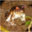

In [12]:
X_train[0] # numpy array (32, 32, 3)

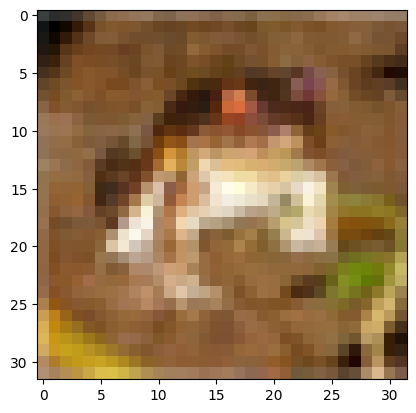

In [13]:
img = plt.imshow(X_train[0])

In [14]:
y_train[0] # according to Keras documentation the label 6 correspond to frog category

array([6], dtype=uint8)

To avoid issues with RAM saturation, we reduce the number of both training and testing images, as the model execution was interrupted when using the complete dataset.

In [15]:
X_train = X_train[:20000]
y_train = y_train[:20000]

In [16]:
X_train.shape

(20000, 32, 32, 3)

In [17]:
X_test = X_test[:4000]
y_test = y_test[:4000]

In [18]:
X_test.shape

(4000, 32, 32, 3)

Since activation functions (e.g., sigmoid, softmax, etc.) produce values in the range of $[0,1]$, we normalize the pixel values within this range to ensure that the inputs to these functions are on a compatible scale. This improves the convergence process of the optimization algorithms and prevents saturation of the activation functions.

By saturation, we refer to the phenomenon in which the outputs of the hidden units cluster near the extremes of the activation function's range. For the sigmoid activation function, these extremes are 0 and 1.

When the outputs are near the asymptotic ends, the gradients of the activation functions become very small. For instance, the derivative of the sigmoid function approaches 0 when the output is close to 0 or 1. Consequently, the weights associated with these saturated neurons receive very little update during training, slowing down learning or causing the model to stop learning altogether.

In [19]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255 # normalize the pixels values to range 0 to 1

In [20]:
X_train[0][0]

array([[0.23137255, 0.24313726, 0.24705882],
       [0.16862746, 0.18039216, 0.1764706 ],
       [0.19607843, 0.1882353 , 0.16862746],
       [0.26666668, 0.21176471, 0.16470589],
       [0.38431373, 0.28627452, 0.20392157],
       [0.46666667, 0.35686275, 0.24705882],
       [0.54509807, 0.41960785, 0.29411766],
       [0.5686275 , 0.43137255, 0.3137255 ],
       [0.58431375, 0.45882353, 0.34901962],
       [0.58431375, 0.47058824, 0.3647059 ],
       [0.5137255 , 0.40392157, 0.3019608 ],
       [0.49019608, 0.3882353 , 0.29803923],
       [0.5568628 , 0.4509804 , 0.35686275],
       [0.5647059 , 0.4392157 , 0.3372549 ],
       [0.5372549 , 0.4117647 , 0.30980393],
       [0.5058824 , 0.38039216, 0.2784314 ],
       [0.5372549 , 0.41568628, 0.30980393],
       [0.5254902 , 0.41568628, 0.29803923],
       [0.4862745 , 0.38039216, 0.2509804 ],
       [0.54509807, 0.44313726, 0.30588236],
       [0.54509807, 0.4392157 , 0.29411766],
       [0.52156866, 0.4117647 , 0.27058825],
       [0.

In [21]:
schema = StructType([
    StructField("label", FloatType(), False),
    StructField("features", ArrayType(FloatType()), False)
]) # to maintain data consistency, the schema is explicitly defined

Define a function to get the dataframe shape in PySpark.

In [22]:
def sparkdf_shape(spark_dataframe):
    return (spark_dataframe.count(), len(spark_dataframe.columns))
pyspark.sql.dataframe.DataFrame.shape = sparkdf_shape

Processing data in batches reduces memory usage, making feasible to work with large datasets that might not fit into memory all at once. During processing, only one batch resides in memory at a time. Once the batch is processed, it can be discarded, freeing up memory for the next batch.

This approach reduces the overall memory usage during the entire processing run.

In [23]:
def process_data(X_data, y_data, batch_size = 10000): # features, labels, and batch size as input parameters
    no_images = X_data.shape[0] # total no. of images
    for i in range(0, no_images, batch_size): # iterate through the entire dataset in increments defined by the batch size
        X_batch = X_data[i:i + batch_size]
        y_batch = y_data[i:i + batch_size]

        X_batch_flattened = X_batch.reshape((X_batch.shape[0], -1)) # convert the 3-dimensional data into a 1-dimensional array keeping the 32*32*3 pixel values

        labels_and_features = [(float(y), [float(val) for val in x]) for x, y in zip(X_batch_flattened, y_batch.flatten())] # list of tuples containing both labels and features
        spark_df = spark.createDataFrame(labels_and_features, schema = schema)  # specify schema explicitly

        yield spark_df # return each spark dataframe immediately

We use `yield` when we want to iterate over a sequence, but don't want to store the entire sequence in memory. It returns each batch immediately as it is obtained, rather than waiting until all batches are processed to return them in a single large collection.

Each time `yield` is called in the function describe above, it outputs the current batch and then pauses. When the function resumes for the next iteration, it overwrites the previous batch with the new one.

This keeps memory usage low by only keeping one batch at a time in memory and discarding it once it's processed, replaced by the next batch in the subsequent iteration.

### Training Set Processing

In [24]:
batches = [] # empty list to batches
for batch_df in process_data(X_train, y_train, batch_size = 10000): # iterate through the batches produced by the function
    print(batch_df) # total no. of batches processed
    batches.append(batch_df) # combine all batches into a single list

DataFrame[label: float, features: array<float>]
DataFrame[label: float, features: array<float>]


In [25]:
train_df = batches[0]
for spark_dataframe in batches[1:]:
    train_df = train_df.union(spark_dataframe) # combines all the spark dataframes (batches) into a single spark dataframe

In [26]:
type(train_df) # spark dataframe

pyspark.sql.dataframe.DataFrame

In [27]:
train_df.printSchema() # schema of the dataframe

root
 |-- label: float (nullable = false)
 |-- features: array (nullable = false)
 |    |-- element: float (containsNull = true)



Upon verifying the schema of the *DataFrame*, we observe that the **features** column is defined as an array of float values. However, the **MLlib** pipelines require the features to be in *vector* format. This is essential for the proper integration of preprocessing, transformation, and model fitting processes within Spark.

In [28]:
array_to_vector = udf(lambda array: Vectors.dense(array), VectorUDT()) # create a user defined function to convert arrays into spark DenseVector objects

In [29]:
train_df = train_df.withColumn("features", array_to_vector(train_df["features"])) # apply the UDF to features column

In [30]:
train_df.printSchema() # schema updated

root
 |-- label: float (nullable = false)
 |-- features: vector (nullable = true)



In [31]:
train_df.show(2) # data preview

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  6.0|[0.23137255012989...|
|  9.0|[0.60392159223556...|
+-----+--------------------+
only showing top 2 rows



### Test Set Processing

In [32]:
batches = [] # empty list to batches
for batch_df in process_data(X_test, y_test, batch_size = 2000): # iterate through the batches produced by the function
    print(batch_df) # total no. of batches processed
    batches.append(batch_df) # combine all batches into a single list

DataFrame[label: float, features: array<float>]
DataFrame[label: float, features: array<float>]


In [33]:
test_df = batches[0]
for spark_dataframe in batches[1:]:
    test_df = test_df.union(spark_dataframe) # combines all the spark dataframes (batches) into a single spark dataframe

In [34]:
test_df.shape() # spark dataframe with 10,000 observations (images) and 2 colmns (labels and features)

(4000, 2)

In [35]:
type(test_df) # spark dataframe

pyspark.sql.dataframe.DataFrame

In [36]:
test_df.printSchema() # schema of the dataframe

root
 |-- label: float (nullable = false)
 |-- features: array (nullable = false)
 |    |-- element: float (containsNull = true)



In [37]:
test_df = test_df.withColumn("features", array_to_vector(test_df["features"])) # apply the UDF to features column

In [38]:
test_df.printSchema() # schema updated

root
 |-- label: float (nullable = false)
 |-- features: vector (nullable = true)



In [39]:
test_df.show(2) # data preview

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  3.0|[0.61960786581039...|
|  8.0|[0.92156863212585...|
+-----+--------------------+
only showing top 2 rows



## Multilayer Perceptron (MLP) Classifier

The multilayer perceptron classifier is a classifier based on the **feedforward neural network**, a type of artificial neural network used in ML applications and pattern recognition. Its architecture consists of multiple layers of nodes, also known as hidden units or neurons, which are fully connected within the network. That is, each node in a previous layer is connected to each node in the next layer. The outputs of each node in a layer $L$ serve as inputs to the nodes in layer $L+1$.

Each node in the hidden layers transforms the values from the previous layer through a linear combination:

$$
w_1 x_1 + w_2 x_2 + ... + w_m x_m
$$

followed by a nonlinear activation function g()g().

Finally, the output layer receives the values from the last hidden layer and transforms them into the output values.

Considering a model with K+1K+1 layers, it can be expressed as:

$$
y(x) = f_k (...f_2(w_2^T f_1(w_1^T x + b_1) + b_2)... + b_k)
$$

$\quad$ where the nodes in the intermediate layers use the sigmoid function defined as:

$$
f(z_i) = \frac{1}{1 + e^{-z_i}},
$$

$\quad$ and the nodes in the output layer use the *softmax* function:

$$
f(z_i) = \frac{e^{z_i}}{\sum_{k = 1}^{N} e^{z_k}}
$$

In [40]:
train_df.persist() # persisting a DataFrame can significantly speed up processing time for iterative algorithms or when multiple actions need to be performed on the same dataframe

DataFrame[label: float, features: vector]

In this case, an input layer is defined with $32 \times 32 \times 3 = 3072$ nodes, two hidden layers with $512$ and $128$ nodes, respectively, and an output layer with $10$ output values.

In [41]:
layers = [3072, 512, 128, 10] # no. of pixel values for input + two hidden layers + 10 output classes

In [42]:
mlp = MultilayerPerceptronClassifier(labelCol = "label", featuresCol = "features",
                                     maxIter = 100, layers = layers, blockSize = 64, seed = 614) # defining a multilayer perceptron classifier
fitted_model = mlp.fit(train_df) # fit the mlp model

### Model Validation and Testing

Calculate predictions using the parameters learned during training.

In [43]:
predictions = fitted_model.transform(test_df) # calculate predictions

In [44]:
predictions.printSchema() # dataframe contains the same columns as before plus additional prediction and probability columns

root
 |-- label: float (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [45]:
predictions.show(2)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  3.0|[0.61960786581039...|[0.15459485043408...|[0.03960567573302...|       3.0|
|  8.0|[0.92156863212585...|[2.18339166279627...|[0.07433233640986...|       8.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 2 rows



In [46]:
predictions_labels = predictions.select("prediction", "label") # get the predicted class for each image and the actual label

In [47]:
predictions_labels.show(2)

+----------+-----+
|prediction|label|
+----------+-----+
|       3.0|  3.0|
|       8.0|  8.0|
+----------+-----+
only showing top 2 rows



#### Assessing Model Accuracy

In [48]:
evaluator = MulticlassClassificationEvaluator(metricName = "accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictions_labels)))

Test set accuracy = 0.43225


In [49]:
no_images = predictions_labels.limit(9).collect() # no. of images to visualize

images = []
labels = []
predictions = [] # empty lists to store images, labels and predictions
i = 0 # index variable to retrieve the images from the test set

for image in no_images:
    label = int(image.label) # true label
    predicted = int(image.prediction) # predicted label
    images.append(X_test[i]) # get the corresponding image from test set

    labels.append(label) # store label
    predictions.append(predicted) # store predicted label
    i += 1 # update the index

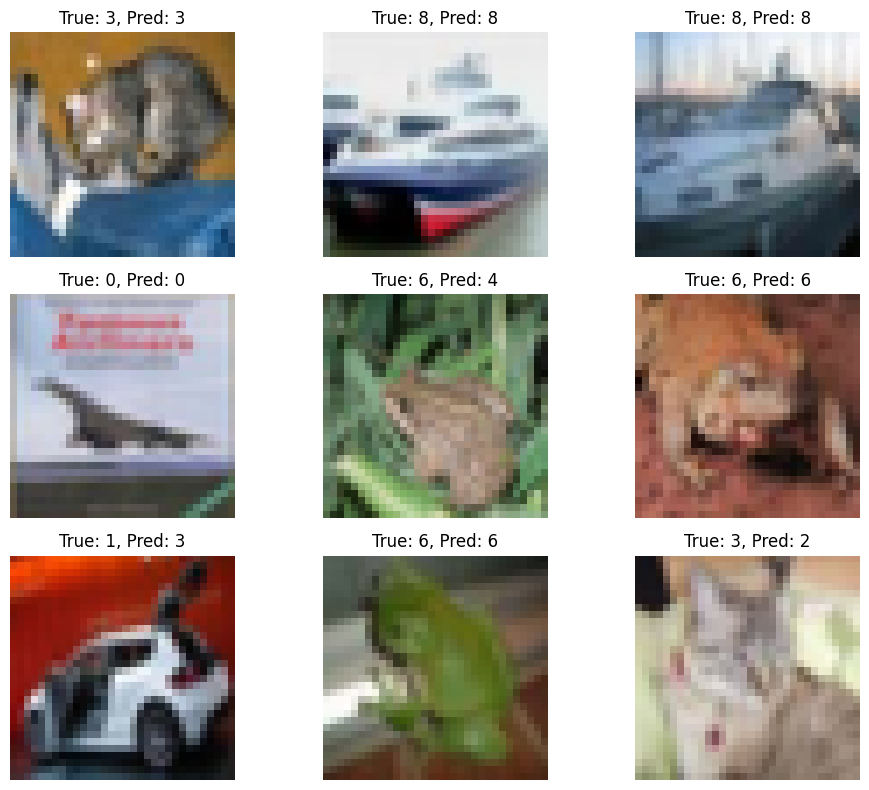

In [50]:
fig, axes = plt.subplots(3, 3, figsize = (10, 8)) # subplot with 3 rows, 3 columns
axes = axes.flatten()

for ax, img, label, prediction in zip(axes, images, labels, predictions):
    ax.imshow(img) # show the image
    ax.set_title(f'True: {label}, Pred: {prediction}') # title with true label and predicted label
    ax.axis('off')

for ax in axes[len(images):]:
    ax.axis('off') # hide any unused axes

plt.tight_layout()
plt.show()

In [51]:
spark.stop() # stop spark session

## Conclusion

Given the accuracy obtained, we can conclude that, in this case, a multilayer perceptron (MLP) classifier is not suitable for performing the classification of this data. Although the model effectively identifies certain patterns, such as in the case of ships, it may overlook relevant patterns and features for the different classes within the dataset.

In this context, we could implement a convolutional neural network (CNN) with the aim of detecting more complex features, such as edges and textures, which may be ignored by the MLP model.

The importance and application of data transformations into a nonlinear representation space are fundamental to improving the model's ability to capture complex relationships. These transformations enable machine learning (ML) models to be more effective in addressing problems involving nonlinear features. The implementation of ML models in Spark through the `MLlib` library facilitates the processing of large volumes of data, optimizing performance and enabling the scalability of the models.

***

November 2024